# Handling Missing Data: Comprehensive Analysis

This notebook demonstrates different techniques for handling missing data:
1. Filling missing values (fillna)
2. Dropping missing values (dropna)
3. Interpolating missing values (interpolate)

Each transformation will be saved as a separate CSV file to preserve the original data.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [2]:
# Load the dataset
df = pd.read_csv('large_missing_data_practice.csv')

# Initial analysis of missing values
print("Dataset Shape:", df.shape)
print("\nMissing Values Summary:")
missing_summary = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_data = pd.DataFrame({
    'Missing Values': missing_summary,
    'Percentage': missing_percentage
})

print(missing_data[missing_data['Missing Values'] > 0].sort_values('Percentage', ascending=False))

Dataset Shape: (100000, 6)

Missing Values Summary:
            Missing Values  Percentage
Income               10000      10.000
Age                   5000       5.000
Department            4971       4.971
Gender                4040       4.040


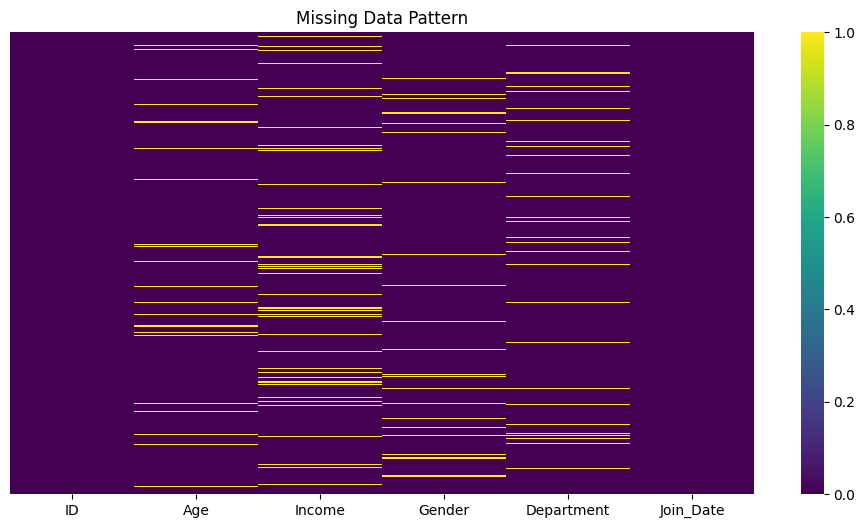

In [3]:
# Visualize missing data patterns
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
plt.title('Missing Data Pattern')
plt.show()

## 1. Filling Missing Values (fillna)

We'll use different strategies for filling missing values based on the data type:

In [4]:
def get_existing_file(prefix):
    """
    Check for existing files with the given prefix and return the first found file.
    """
    files = [f for f in os.listdir() if f.startswith(prefix) and f.endswith('.csv')]
    if files:
        return files[0]
    return None

def fill_missing_values(df):
    # Check if filled data file already exists
    existing_file = get_existing_file('filled_data_')
    if existing_file:
        print(f"Using existing filled data file: {existing_file}")
        return pd.read_csv(existing_file)
    
    df_filled = df.copy()
    
    # Identify numeric and categorical columns
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_columns = df.select_dtypes(include=['object']).columns
    
    # Fill numeric columns
    for col in numeric_columns:
        # Fill with mean for columns with less than 30% missing values
        if df[col].isnull().sum() / len(df) < 0.3:
            df_filled[col].fillna(df[col].mean(), inplace=True)
        else:
            # Fill with median for columns with more missing values
            df_filled[col].fillna(df[col].median(), inplace=True)
    
    # Fill categorical columns
    for col in categorical_columns:
        # Fill with mode
        df_filled[col].fillna(df[col].mode()[0], inplace=True)
    
    # Save the filled dataset
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    output_file = f'filled_data_{timestamp}.csv'
    df_filled.to_csv(output_file, index=False)
    print(f"Filled data saved to: {output_file}")
    
    return df_filled

# Apply fillna strategy
df_filled = fill_missing_values(df)

# Compare missing values before and after
print("\nMissing values after filling:")
print(df_filled.isnull().sum()[df_filled.isnull().sum() > 0])

Using existing filled data file: filled_data_20250614_181200.csv

Missing values after filling:
Series([], dtype: int64)


## 2. Dropping Missing Values (dropna)

We'll implement different dropping strategies:

In [5]:
def drop_missing_values(df):
    results = {}
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Check for existing files
    existing_all = get_existing_file('dropped_all_missing_')
    existing_50 = get_existing_file('dropped_50percent_')
    existing_cols = get_existing_file('dropped_columns_')
    
    if all([existing_all, existing_50, existing_cols]):
        print("Using existing dropped data files:")
        print(f"All missing: {existing_all}")
        print(f"50% threshold: {existing_50}")
        print(f"Dropped columns: {existing_cols}")
        return pd.read_csv(existing_50)  # Return the most balanced version
    
    # 1. Drop rows with all missing values
    df_dropall = df.dropna(how='all')
    df_dropall.to_csv(f'dropped_all_missing_{timestamp}.csv', index=False)
    results['drop_all'] = len(df) - len(df_dropall)
    
    # 2. Drop rows with > 50% missing values
    threshold = len(df.columns) * 0.5
    df_drop50 = df.dropna(thresh=threshold)
    df_drop50.to_csv(f'dropped_50percent_{timestamp}.csv', index=False)
    results['drop_50'] = len(df) - len(df_drop50)
    
    # 3. Drop columns with > 70% missing values
    missing_percent = df.isnull().sum() / len(df)
    cols_to_drop = missing_percent[missing_percent > 0.7].index
    df_dropcols = df.drop(columns=cols_to_drop)
    df_dropcols.to_csv(f'dropped_columns_{timestamp}.csv', index=False)
    results['dropped_columns'] = len(cols_to_drop)
    
    print("\nDropping Results:")
    print(f"Rows dropped (all missing): {results['drop_all']}")
    print(f"Rows dropped (>50% missing): {results['drop_50']}")
    print(f"Columns dropped (>70% missing): {results['dropped_columns']}")
    
    return df_drop50  # Return the most balanced version

# Apply dropna strategies
df_dropped = drop_missing_values(df)

Using existing dropped data files:
All missing: dropped_all_missing_20250614_181200.csv
50% threshold: dropped_50percent_20250614_181200.csv
Dropped columns: dropped_columns_20250614_181200.csv


## 3. Interpolating Missing Values

We'll use various interpolation methods:

In [6]:
def interpolate_missing_values(df):
    # Check for existing files
    existing_linear = get_existing_file('interpolated_linear_')
    existing_poly = get_existing_file('interpolated_polynomial_')
    existing_spline = get_existing_file('interpolated_spline_')
    
    if all([existing_linear, existing_poly, existing_spline]):
        print("Using existing interpolated data files:")
        print(f"Linear: {existing_linear}")
        print(f"Polynomial: {existing_poly}")
        print(f"Spline: {existing_spline}")
        return (pd.read_csv(existing_linear),
                pd.read_csv(existing_poly),
                pd.read_csv(existing_spline))
    
    # Create copies for different interpolation methods
    df_linear = df.copy()
    df_polynomial = df.copy()
    df_spline = df.copy()
    
    # Get numeric columns
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    
    # 1. Linear interpolation
    for col in numeric_columns:
        df_linear[col] = df_linear[col].interpolate(method='linear')
    
    # 2. Polynomial interpolation
    for col in numeric_columns:
        df_polynomial[col] = df_polynomial[col].interpolate(method='polynomial', order=2)
    
    # 3. Cubic spline interpolation
    for col in numeric_columns:
        df_spline[col] = df_spline[col].interpolate(method='cubic')
    
    # Save results
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    df_linear.to_csv(f'interpolated_linear_{timestamp}.csv', index=False)
    df_polynomial.to_csv(f'interpolated_polynomial_{timestamp}.csv', index=False)
    df_spline.to_csv(f'interpolated_spline_{timestamp}.csv', index=False)
    
    # Compare results
    print("\nMissing values after interpolation:")
    print("\nLinear interpolation:")
    print(df_linear[numeric_columns].isnull().sum())
    print("\nPolynomial interpolation:")
    print(df_polynomial[numeric_columns].isnull().sum())
    print("\nCubic spline interpolation:")
    print(df_spline[numeric_columns].isnull().sum())
    
    return df_linear, df_polynomial, df_spline

# Apply interpolation strategies
df_linear, df_polynomial, df_spline = interpolate_missing_values(df)

Using existing interpolated data files:
Linear: interpolated_linear_20250614_181201.csv
Polynomial: interpolated_polynomial_20250614_181201.csv
Spline: interpolated_spline_20250614_181201.csv


## Comparison of Methods

Let's compare the results of different methods:

Missing Values Comparison:
            Original  Filled  Dropped  Interpolated
Age             5000       0     4998             0
Income         10000       0     9998             0
Gender          4040       0     4038          4040
Department      4971       0     4969          4971

Statistics Comparison:
                  ID_stats  Age_stats  Income_stats
Original      50000.500000   53.34040  50043.060228
Filled        50000.500000   53.34040  50043.060228
Dropped       50000.138363   53.34040  50043.060228
Interpolated  50000.500000   53.34674  50046.442846

Sample of filled dataset:


,ID,Age,Income,Gender,Department,Join_Date
0,1,69.0,37113.136318,Female,Finance,2015-09-25
1,2,32.0,18677.838123,Male,Sales,2020-12-01
2,3,89.0,45993.800470,Male,Sales,2018-03-27
3,4,78.0,59916.937321,Male,Finance,2014-05-08
4,5,38.0,42513.232751,Female,Finance,2012-06-06



Descriptive statistics of filled dataset:


,ID,Age,Income
count,100000.000000,100000.000000,100000.000000
mean,50000.500000,53.340400,50043.060228
std,28867.657797,20.229967,14191.057539
min,1.000000,18.000000,-16848.392203
25%,25000.750000,36.000000,41196.328416
50%,50000.500000,53.340400,50043.060228
75%,75000.250000,70.000000,58856.868731
max,100000.000000,89.000000,115348.767895


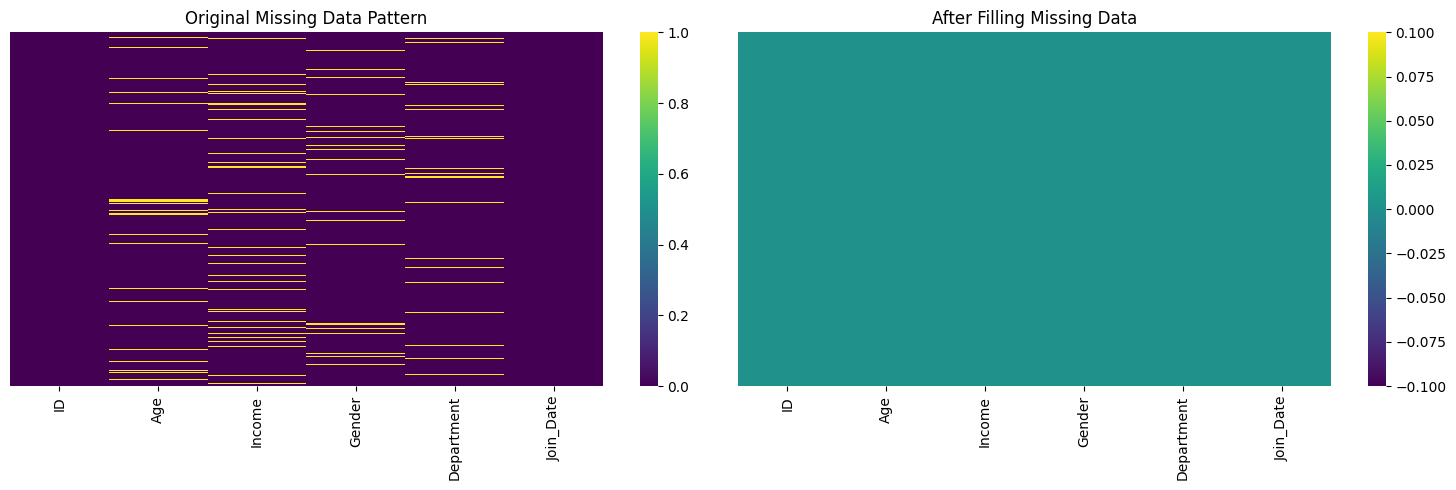


Sample of dataset after dropping rows:


,ID,Age,Income,Gender,Department,Join_Date
0,1,69.0,37113.136318,Female,Finance,2015-09-25
1,2,32.0,18677.838123,Male,Sales,2020-12-01
2,3,89.0,45993.800470,Male,Sales,2018-03-27
3,4,78.0,59916.937321,Male,Finance,2014-05-08
4,5,38.0,42513.232751,Female,Finance,2012-06-06



Shape comparison:
Original shape: (100000, 6)
After dropping: (99998, 6)


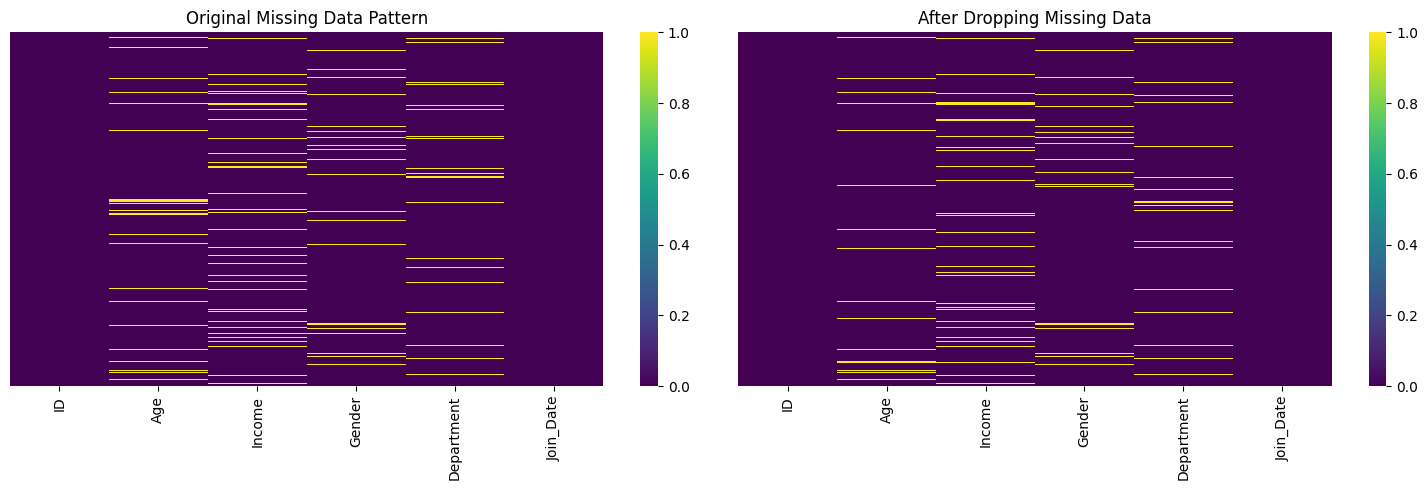


Sample of linearly interpolated dataset:


,ID,Age,Income,Gender,Department,Join_Date
0,1,69.0,37113.136318,Female,Finance,2015-09-25
1,2,32.0,18677.838123,Male,Sales,2020-12-01
2,3,89.0,45993.800470,Male,Sales,2018-03-27
3,4,78.0,59916.937321,Male,Finance,2014-05-08
4,5,38.0,42513.232751,Female,Finance,2012-06-06



Sample of polynomial interpolated dataset:


,ID,Age,Income,Gender,Department,Join_Date
0,1,69.0,37113.136318,Female,Finance,2015-09-25
1,2,32.0,18677.838123,Male,Sales,2020-12-01
2,3,89.0,45993.800470,Male,Sales,2018-03-27
3,4,78.0,59916.937321,Male,Finance,2014-05-08
4,5,38.0,42513.232751,Female,Finance,2012-06-06



Sample of spline interpolated dataset:


,ID,Age,Income,Gender,Department,Join_Date
0,1,69.0,37113.136318,Female,Finance,2015-09-25
1,2,32.0,18677.838123,Male,Sales,2020-12-01
2,3,89.0,45993.800470,Male,Sales,2018-03-27
3,4,78.0,59916.937321,Male,Finance,2014-05-08
4,5,38.0,42513.232751,Female,Finance,2012-06-06


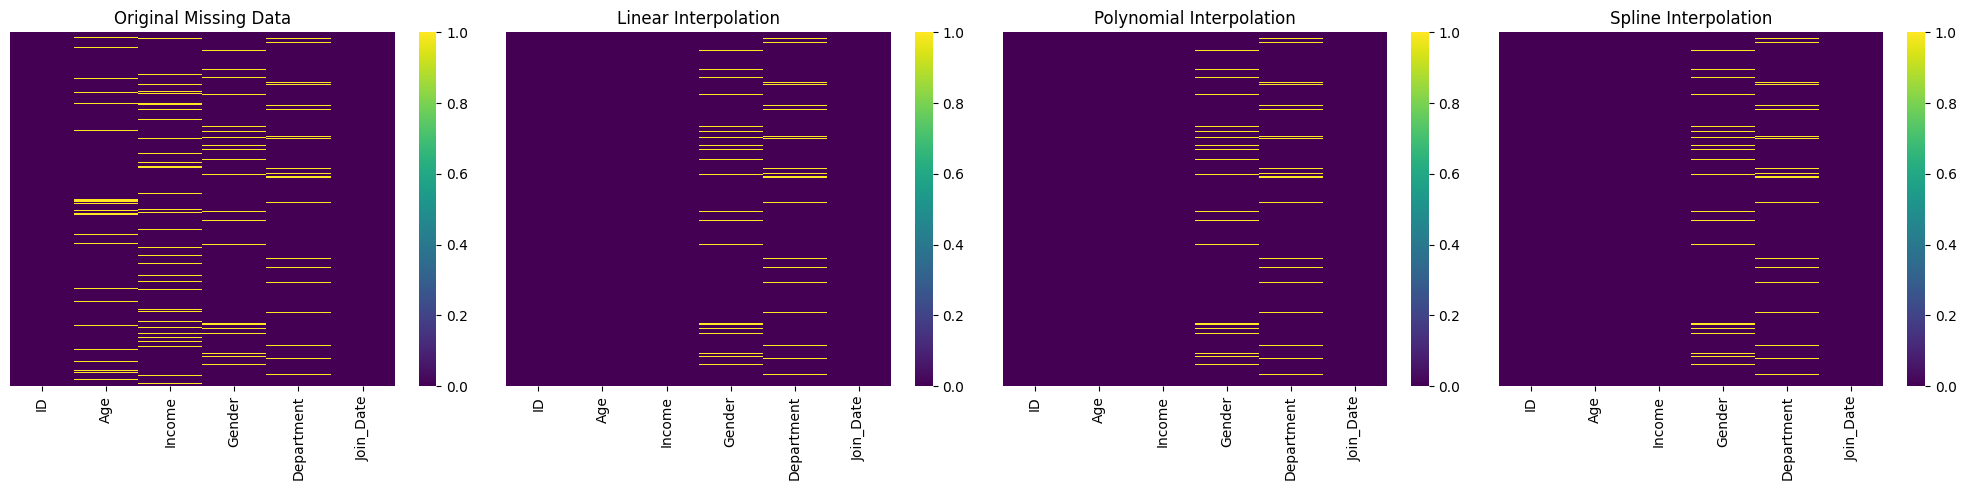


Summary Statistics Comparison for Numeric Columns:


,Original,Filled,Dropped,Linear_Interp,Poly_Interp,Spline_Interp
ID,50000.500000,50000.500000,50000.138363,50000.500000,50000.500000,50000.500000
Age,53.340400,53.340400,53.340400,53.346740,53.347039,53.346796
Income,50043.060228,50043.060228,50043.060228,50046.442846,50060.224323,50063.016355


In [7]:
def compare_methods(df_original, df_filled, df_dropped, df_linear):
    comparison = pd.DataFrame({
        'Original': df_original.isnull().sum(),
        'Filled': df_filled.isnull().sum(),
        'Dropped': df_dropped.isnull().sum(),
        'Interpolated': df_linear.isnull().sum()
    })
    
    # Calculate statistics for numeric columns
    numeric_cols = df_original.select_dtypes(include=['int64', 'float64']).columns
    stats_comparison = pd.DataFrame()
    
    for col in numeric_cols:
        stats_comparison[f'{col}_stats'] = [
            df_original[col].mean(),
            df_filled[col].mean(),
            df_dropped[col].mean(),
            df_linear[col].mean()
        ]
    
    stats_comparison.index = ['Original', 'Filled', 'Dropped', 'Interpolated']
    
    print("Missing Values Comparison:")
    print(comparison[comparison['Original'] > 0])
    print("\nStatistics Comparison:")
    print(stats_comparison)
    
    # Save comparison results
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    comparison.to_csv(f'missing_values_comparison_{timestamp}.csv')
    stats_comparison.to_csv(f'statistics_comparison_{timestamp}.csv')

# Compare all methods
compare_methods(df, df_filled, df_dropped, df_linear)

# After fillna operation
print("\nSample of filled dataset:")
display(df_filled.head())
print("\nDescriptive statistics of filled dataset:")
display(df_filled.describe())

# Visualize the changes
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
plt.title('Original Missing Data Pattern')
plt.subplot(1, 2, 2)
sns.heatmap(df_filled.isnull(), yticklabels=False, cbar=True, cmap='viridis')
plt.title('After Filling Missing Data')
plt.tight_layout()
plt.show()

# After dropna operations
print("\nSample of dataset after dropping rows:")
display(df_dropped.head())
print("\nShape comparison:")
print(f"Original shape: {df.shape}")
print(f"After dropping: {df_dropped.shape}")

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
plt.title('Original Missing Data Pattern')
plt.subplot(1, 2, 2)
sns.heatmap(df_dropped.isnull(), yticklabels=False, cbar=True, cmap='viridis')
plt.title('After Dropping Missing Data')
plt.tight_layout()
plt.show()

# After interpolation
print("\nSample of linearly interpolated dataset:")
display(df_linear.head())
print("\nSample of polynomial interpolated dataset:")
display(df_polynomial.head())
print("\nSample of spline interpolated dataset:")
display(df_spline.head())

plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
plt.title('Original Missing Data')
plt.subplot(1, 4, 2)
sns.heatmap(df_linear.isnull(), yticklabels=False, cbar=True, cmap='viridis')
plt.title('Linear Interpolation')
plt.subplot(1, 4, 3)
sns.heatmap(df_polynomial.isnull(), yticklabels=False, cbar=True, cmap='viridis')
plt.title('Polynomial Interpolation')
plt.subplot(1, 4, 4)
sns.heatmap(df_spline.isnull(), yticklabels=False, cbar=True, cmap='viridis')
plt.title('Spline Interpolation')
plt.tight_layout()
plt.show()

# Add summary statistics comparison
print("\nSummary Statistics Comparison for Numeric Columns:")
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
comparison_df = pd.DataFrame({
    'Original': df[numeric_cols].mean(),
    'Filled': df_filled[numeric_cols].mean(),
    'Dropped': df_dropped[numeric_cols].mean(),
    'Linear_Interp': df_linear[numeric_cols].mean(),
    'Poly_Interp': df_polynomial[numeric_cols].mean(),
    'Spline_Interp': df_spline[numeric_cols].mean()
})
display(comparison_df)

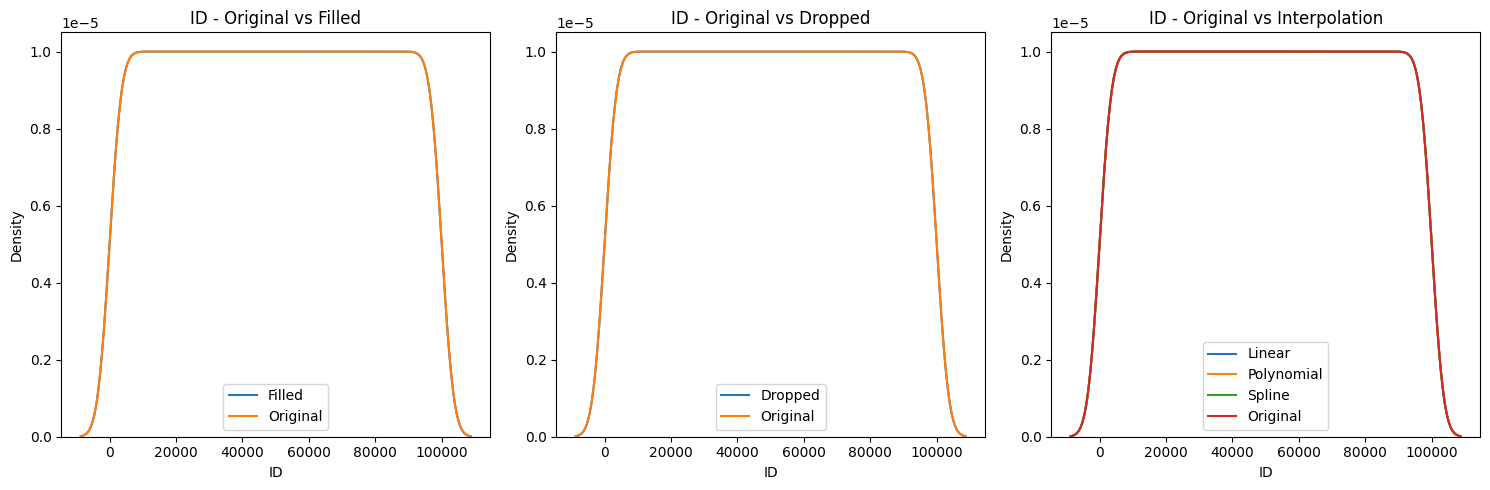

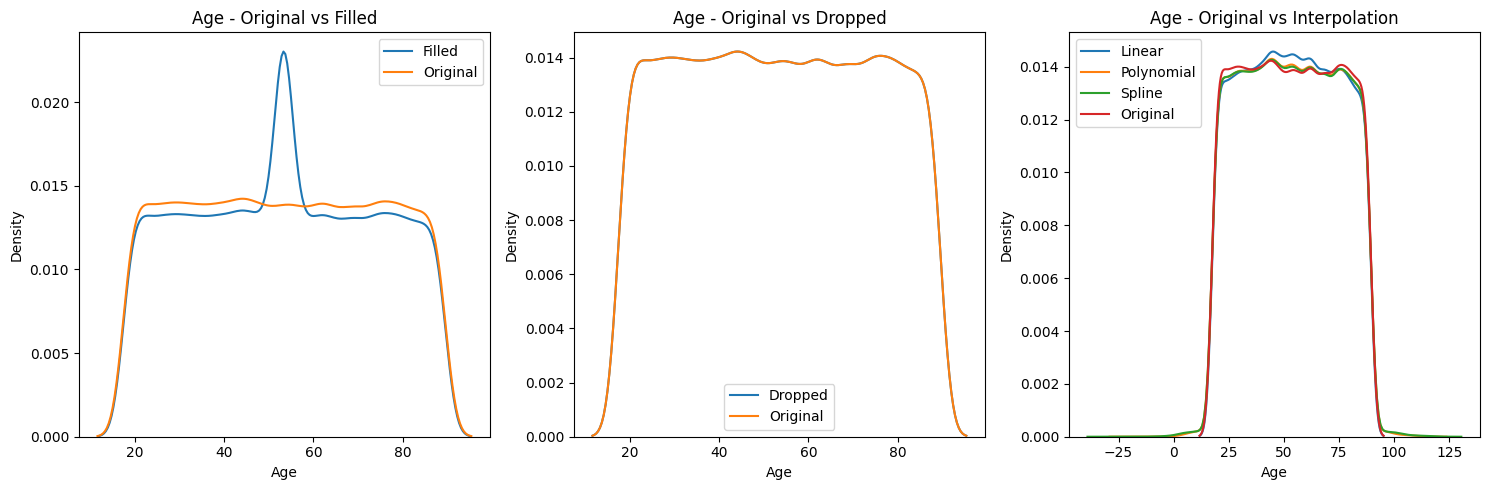

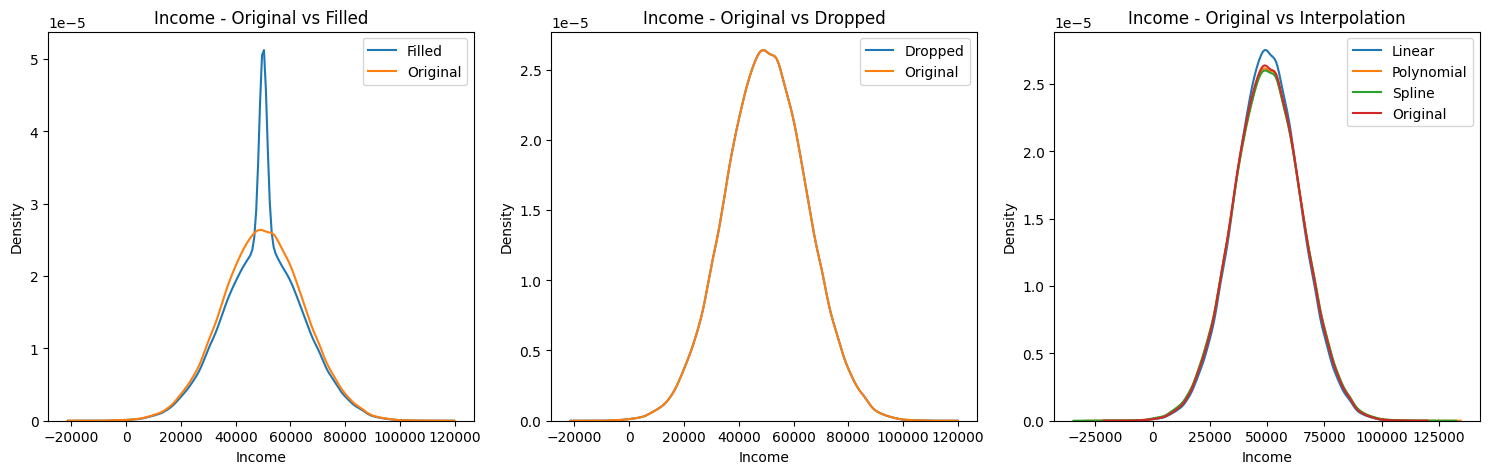


Detailed Statistics Comparison:


,Column,Original_Mean,Original_Std,Filled_Mean,Filled_Std,Dropped_Mean,Dropped_Std,Linear_Mean,Linear_Std,Poly_Mean,Poly_Std,Spline_Mean,Spline_Std
0,ID,50000.500000,28867.657797,50000.500000,28867.657797,50000.138363,28867.833064,50000.500000,28867.657797,50000.500000,28867.657797,50000.500000,28867.657797
1,Age,53.340400,20.755514,53.340400,20.229967,53.340400,20.755514,53.346740,20.496190,53.347039,20.848729,53.346796,20.925719
2,Income,50043.060228,14958.696387,50043.060228,14191.057539,50043.060228,14958.696387,50046.442846,14590.061210,50060.224323,15164.500869,50063.016355,15278.616359



Percentage of Missing Values Handled by Each Method:


,Method,Missing_Values,Percentage_Handled
0,Original,24011,0.000000
1,Filled,0,100.000000
2,Dropped,24003,0.033318
3,Linear,9011,62.471367
4,Polynomial,9011,62.471367
5,Spline,9011,62.471367


In [8]:
# Distribution plots for numeric columns to compare methods
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols[:3]:  # Plot first 3 numeric columns as an example
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    sns.kdeplot(data=df_filled[col], label='Filled')
    sns.kdeplot(data=df[col].dropna(), label='Original')
    plt.title(f'{col} - Original vs Filled')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    sns.kdeplot(data=df_dropped[col], label='Dropped')
    sns.kdeplot(data=df[col].dropna(), label='Original')
    plt.title(f'{col} - Original vs Dropped')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    sns.kdeplot(data=df_linear[col], label='Linear')
    sns.kdeplot(data=df_polynomial[col], label='Polynomial')
    sns.kdeplot(data=df_spline[col], label='Spline')
    sns.kdeplot(data=df[col].dropna(), label='Original')
    plt.title(f'{col} - Original vs Interpolation')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Create a summary table of key statistics for each method
summary_stats = []
for col in numeric_cols:
    stats = {
        'Column': col,
        'Original_Mean': df[col].mean(),
        'Original_Std': df[col].std(),
        'Filled_Mean': df_filled[col].mean(),
        'Filled_Std': df_filled[col].std(),
        'Dropped_Mean': df_dropped[col].mean(),
        'Dropped_Std': df_dropped[col].std(),
        'Linear_Mean': df_linear[col].mean(),
        'Linear_Std': df_linear[col].std(),
        'Poly_Mean': df_polynomial[col].mean(),
        'Poly_Std': df_polynomial[col].std(),
        'Spline_Mean': df_spline[col].mean(),
        'Spline_Std': df_spline[col].std()
    }
    summary_stats.append(stats)

summary_df = pd.DataFrame(summary_stats)
print("\nDetailed Statistics Comparison:")
display(summary_df)

# Calculate and display the percentage of missing values handled by each method
total_missing = df.isnull().sum().sum()
missing_comparison = pd.DataFrame({
    'Method': ['Original', 'Filled', 'Dropped', 'Linear', 'Polynomial', 'Spline'],
    'Missing_Values': [
        df.isnull().sum().sum(),
        df_filled.isnull().sum().sum(),
        df_dropped.isnull().sum().sum(),
        df_linear.isnull().sum().sum(),
        df_polynomial.isnull().sum().sum(),
        df_spline.isnull().sum().sum()
    ]
})
missing_comparison['Percentage_Handled'] = 100 * (1 - missing_comparison['Missing_Values'] / total_missing)

print("\nPercentage of Missing Values Handled by Each Method:")
display(missing_comparison)

## 4. Replace Missing Values

This method replaces missing values based on specific conditions:
1. Replace with a custom value based on business logic
2. Replace based on other column values
3. Replace using rolling statistics
4. Replace using forward/backward fill for time-based data

Using existing replaced data file: replaced_data_20250614_232248.csv

Visualizing the changes...


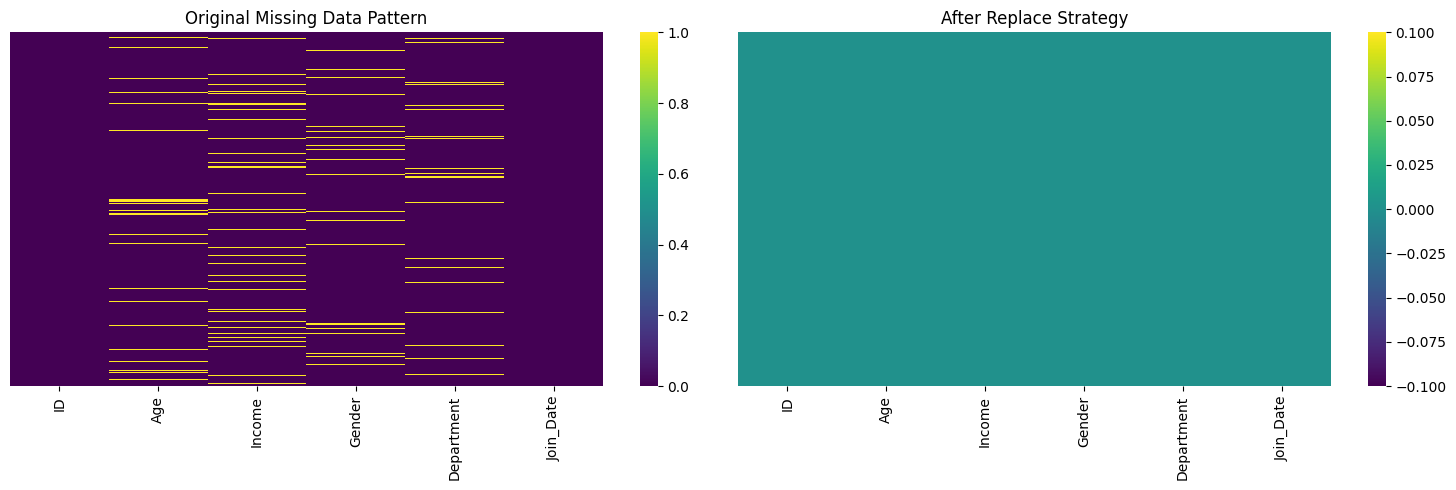


Comparison of Original vs Replaced Data:


,Original_Mean,Replaced_Mean,Original_Std,Replaced_Std,Original_Missing,Replaced_Missing
ID,50000.500000,50000.500000,28867.657797,28867.657797,0,0
Age,53.340400,53.340400,20.755514,20.229967,5000,0
Income,50043.060228,50043.060228,14958.696387,14191.057539,10000,0



Value counts comparison for Gender:

Original:


Gender
Female    48022
Male      47938
Name: count, dtype: int64


Replaced:


Gender
Female     48022
Male       47938
Unknown     4040
Name: count, dtype: int64


Value counts comparison for Department:

Original:


Department
Sales          25127
Finance        24957
Engineering    24910
HR             20035
Name: count, dtype: int64


Replaced:


Department
Sales          25127
Finance        24957
Engineering    24910
HR             20035
Unknown         4971
Name: count, dtype: int64


Value counts comparison for Join_Date:

Original:


Join_Date
2017-01-05    45
2012-02-10    44
2016-06-27    43
2010-12-22    42
2018-07-20    42
Name: count, dtype: int64


Replaced:


Join_Date
2017-01-05    45
2012-02-10    44
2016-06-27    43
2010-12-22    42
2018-07-20    42
Name: count, dtype: int64

C:\Users\RISHAB ARYA\AppData\Local\Temp\ipykernel_15932\2572131277.py:153: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


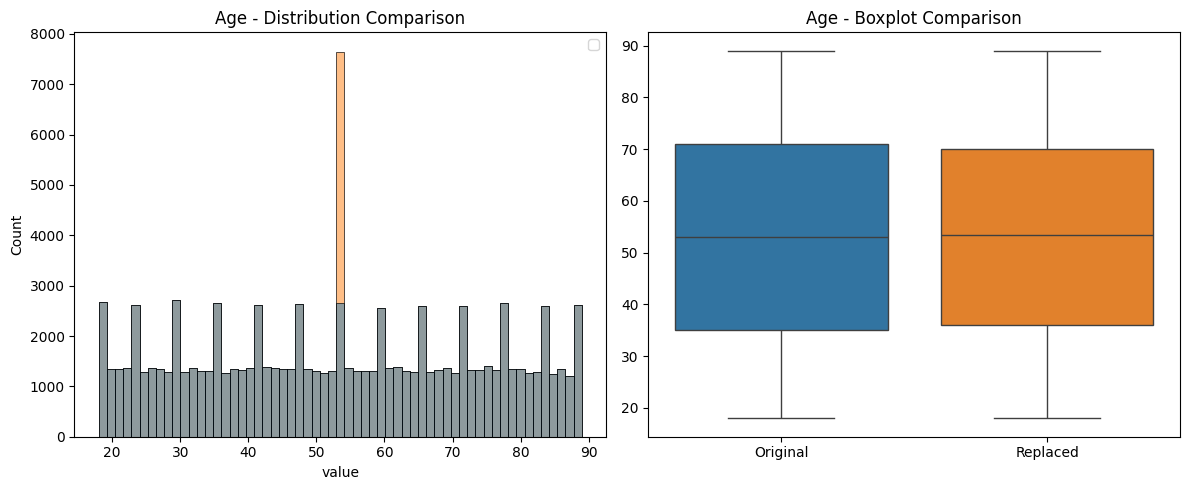


Summary statistics for Age:

Original:


count    95000.000000
mean        53.340400
std         20.755514
min         18.000000
25%         35.000000
50%         53.000000
75%         71.000000
max         89.000000
Name: Age, dtype: float64


Replaced:


count    100000.000000
mean         53.340400
std          20.229967
min          18.000000
25%          36.000000
50%          53.340400
75%          70.000000
max          89.000000
Name: Age, dtype: float64

C:\Users\RISHAB ARYA\AppData\Local\Temp\ipykernel_15932\2572131277.py:153: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


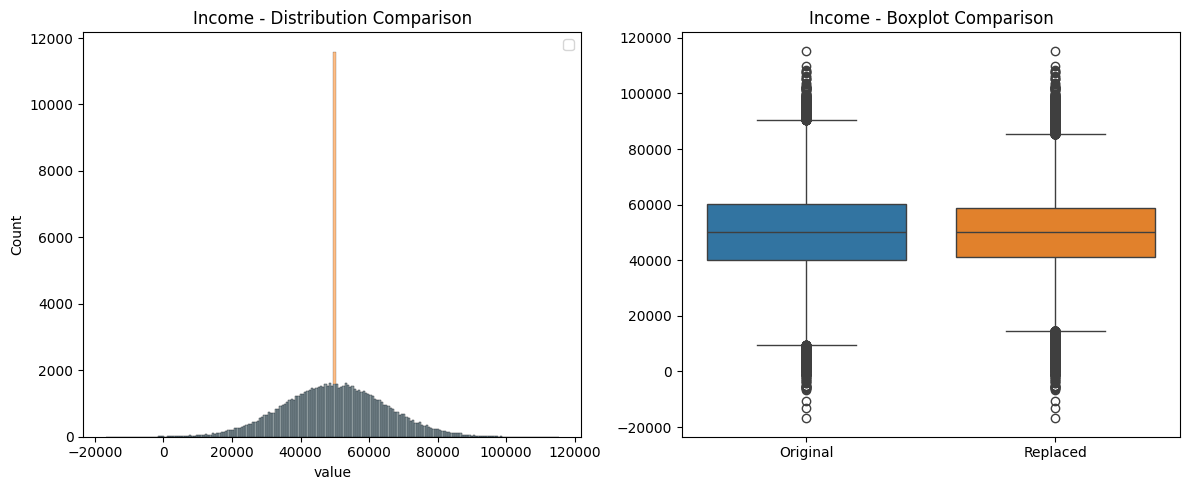


Summary statistics for Income:

Original:


count     90000.000000
mean      50043.060228
std       14958.696387
min      -16848.392203
25%       39929.558125
50%       49998.999418
75%       60131.096331
max      115348.767895
Name: Income, dtype: float64


Replaced:


count    100000.000000
mean      50043.060228
std       14191.057539
min      -16848.392203
25%       41196.328416
50%       50043.060228
75%       58856.868731
max      115348.767895
Name: Income, dtype: float64

In [9]:
def replace_missing_values(df):
    # Check if replaced data file already exists
    existing_file = get_existing_file('replaced_data_')
    if existing_file:
        print(f"Using existing replaced data file: {existing_file}")
        return pd.read_csv(existing_file)
    
    df_replaced = df.copy()
    
    # Get numeric and categorical columns
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_columns = df.select_dtypes(include=['object']).columns
    
    # Create replacement dictionaries dynamically based on actual columns
    replacement_dicts = {}
    
    # For numeric columns
    for col in numeric_columns:
        try:
            replacement_dicts[col] = {
                np.nan: df[col].mean(),  # replace missing with mean
                0: df[col].median() if df[col].median() != 0 else df[col].mean(),  # replace zeros with median or mean
                -1: df[col].mode()[0] if not df[col].mode().empty else df[col].mean()  # replace -1 with mode or mean
            }
        except Exception as e:
            print(f"Warning: Could not create replacement dictionary for {col}: {str(e)}")
            continue
    
    # For categorical columns
    for col in categorical_columns:
        if col != 'ID':  # Skip ID column if it exists
            replacement_dicts[col] = {
                np.nan: 'Unknown',
                '': 'Not Specified',
                'N/A': 'Not Available',
                'unknown': 'Other',
                'Unknown': 'Other',
                'na': 'Not Available',
                'NA': 'Not Available'
            }
    
    # Print the columns that will be processed
    print("\nColumns to be processed with dictionary replacement:")
    for col in replacement_dicts.keys():
        print(f"- {col}")
    
    # 1. Replace using dictionary mapping for specific columns
    for column, replace_dict in replacement_dicts.items():
        try:
            if column in df_replaced.columns:
                print(f"Applying dictionary replacement for column: {column}")
                df_replaced[column] = df_replaced[column].replace(replace_dict)
        except Exception as e:
            print(f"Warning: Error while processing {column}: {str(e)}")
            continue
    
    # 2. Handle any remaining missing values
    for col in df_replaced.columns:
        if df_replaced[col].isnull().any():
            try:
                if col in numeric_columns:
                    # Use rolling statistics for remaining missing values
                    window_size = 3
                    df_replaced[col] = df_replaced[col].fillna(method='ffill')
                    rolling_mean = df_replaced[col].rolling(window=window_size, min_periods=1).mean()
                    df_replaced[col] = df_replaced[col].fillna(rolling_mean)
                
                elif col in categorical_columns and col != 'ID':  # Skip ID column
                    # Forward fill first
                    df_replaced[col] = df_replaced[col].fillna(method='ffill')
                    # Backward fill for remaining missing values
                    df_replaced[col] = df_replaced[col].fillna(method='bfill')
                    # If still any missing values, replace with mode
                    if df_replaced[col].isnull().any():
                        mode_value = df_replaced[col].mode()[0] if not df_replaced[col].mode().empty else 'Unknown'
                        df_replaced[col] = df_replaced[col].fillna(mode_value)
            except Exception as e:
                print(f"Warning: Error while handling remaining missing values in {col}: {str(e)}")
                continue
    
    # Save the replaced dataset
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    output_file = f'replaced_data_{timestamp}.csv'
    df_replaced.to_csv(output_file, index=False)
    print(f"\nReplaced data saved to: {output_file}")
    
    # Print missing value summary after replacement
    missing_after = df_replaced.isnull().sum()
    if missing_after.any():
        print("\nRemaining missing values after replacement:")
        print(missing_after[missing_after > 0])
    else:
        print("\nAll missing values have been successfully replaced!")
    
    return df_replaced

# Apply replace strategy
df_replaced = replace_missing_values(df)

# Display results and comparisons
print("\nVisualizing the changes...")

# Visualize the changes
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
plt.title('Original Missing Data Pattern')
plt.subplot(1, 2, 2)
sns.heatmap(df_replaced.isnull(), yticklabels=False, cbar=True, cmap='viridis')
plt.title('After Replace Strategy')
plt.tight_layout()
plt.show()

# Compare statistics between original and replaced data
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
stats_comparison = pd.DataFrame({
    'Original_Mean': df[numeric_cols].mean(),
    'Replaced_Mean': df_replaced[numeric_cols].mean(),
    'Original_Std': df[numeric_cols].std(),
    'Replaced_Std': df_replaced[numeric_cols].std(),
    'Original_Missing': df[numeric_cols].isnull().sum(),
    'Replaced_Missing': df_replaced[numeric_cols].isnull().sum()
})

print("\nComparison of Original vs Replaced Data:")
display(stats_comparison)

# Add value counts comparison for categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col in df.columns and col != 'ID':  # Skip ID column
        print(f"\nValue counts comparison for {col}:")
        print("\nOriginal:")
        display(df[col].value_counts().head())
        print("\nReplaced:")
        display(df_replaced[col].value_counts().head())

# Add distribution plots to compare original vs replaced data
for col in numeric_cols:  # Plot numeric columns
    if col != 'ID':  # Skip ID column
        # Create a DataFrame for plotting
        plot_data = pd.DataFrame({
            'Original': df[col].dropna(),
            'Replaced': df_replaced[col]
        })
        
        plt.figure(figsize=(12, 5))
        
        # Distribution plot
        plt.subplot(1, 2, 1)
        sns.histplot(data=plot_data.melt(), x='value', hue='variable', alpha=0.5, multiple="layer")
        plt.title(f'{col} - Distribution Comparison')
        plt.legend()
        
        # Box plot
        plt.subplot(1, 2, 2)
        sns.boxplot(data=plot_data)
        plt.title(f'{col} - Boxplot Comparison')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print(f"\nSummary statistics for {col}:")
        print("\nOriginal:")
        display(df[col].describe())
        print("\nReplaced:")
        display(df_replaced[col].describe())